In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import all_estimators
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, classification_report,precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.inspection import permutation_importance
from sklearn.exceptions import ConvergenceWarning
import optuna
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [2]:
df = pd.read_csv("/kaggle/input/socialanxietyfeatureengineer/OriginalFeaturesAdded (1).csv")

In [3]:
df

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),...,Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10),Caffeine_Sleep_Ratio,Heart_Breathing_Ratio,Diet_Quality_Binary,Active_Therapy
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,...,No,Yes,3,Yes,7,5.0,30.166667,8.142857,1,1
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,...,Yes,No,2,No,8,3.0,32.258065,2.695652,1,1
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,...,No,No,1,Yes,1,1.0,23.400000,3.250000,0,0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,...,No,No,0,No,1,2.0,62.068966,5.058824,0,0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,...,Yes,Yes,1,No,3,1.0,30.121951,5.157895,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,23,Female,Engineer,6.1,3.1,566,9,Yes,No,8,...,Yes,Yes,1,No,3,6.0,92.786885,3.250000,0,0
10996,50,Other,Teacher,6.6,3.6,64,17,Yes,No,7,...,No,No,2,No,7,3.0,9.696970,5.588235,1,1
10997,29,Male,Nurse,6.7,6.9,159,14,No,No,8,...,Yes,Yes,2,Yes,7,4.0,23.731343,4.500000,1,1
10998,53,Other,Artist,5.7,2.7,248,8,No,No,4,...,Yes,Yes,1,Yes,2,4.0,43.508772,4.000000,0,0


In [6]:
int_cols = df.select_dtypes(include=("number"))

In [8]:
corr = int_cols.corr()

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

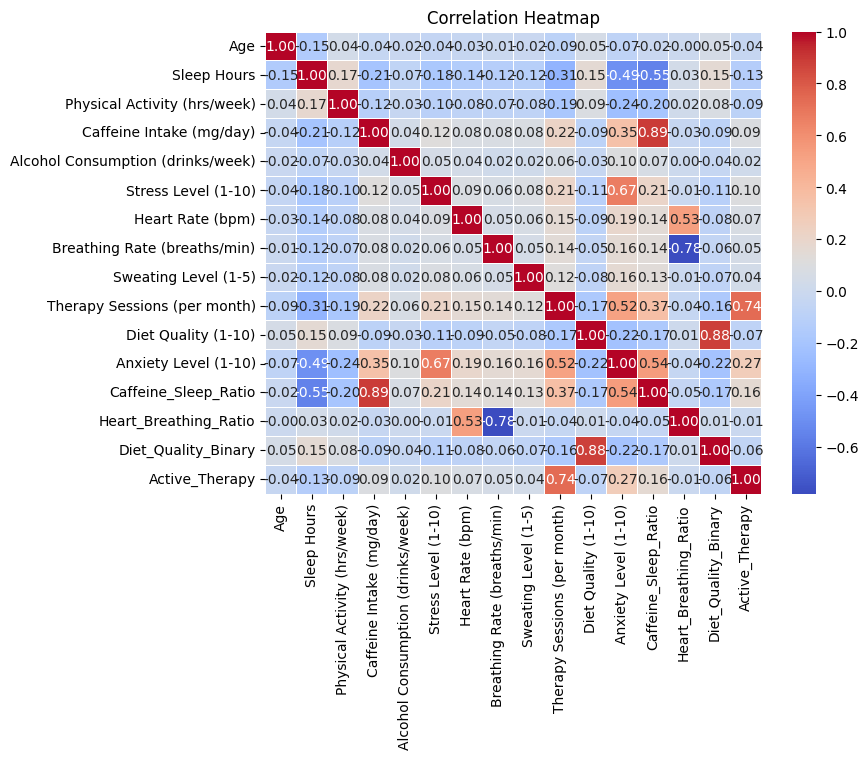

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [12]:
target_original = 'Anxiety Level (1-10)'
def categorize_anxiety(level):
    level = int(level) if isinstance(level, str) else level
    if level <= 3:
        return 'Low'
    elif 3 < level <= 6:
        return 'Medium'
    else: 
        return 'High'

df['Anxiety Class'] = df[target_original].apply(categorize_anxiety).astype('category')
target_col = 'Anxiety Class'
df = df.drop(columns=[target_original])

numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"Числові колонки ({len(numeric_cols)}): {numeric_cols}")
print(f"Категоріальні колонки ({len(categorical_cols)}): {categorical_cols}")
print(f"Цільова змінна: {target_col}")

Числові колонки (15): ['Age', 'Sleep Hours', 'Physical Activity (hrs/week)', 'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)', 'Stress Level (1-10)', 'Heart Rate (bpm)', 'Breathing Rate (breaths/min)', 'Sweating Level (1-5)', 'Therapy Sessions (per month)', 'Diet Quality (1-10)', 'Caffeine_Sleep_Ratio', 'Heart_Breathing_Ratio', 'Diet_Quality_Binary', 'Active_Therapy']
Категоріальні колонки (7): ['Gender', 'Occupation', 'Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']
Цільова змінна: Anxiety Class


In [16]:
label_encoders = {}
df_encoded = df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"Закодовано {col}: {len(le.classes_)} унікальних значень")

le_y = LabelEncoder()
y = le_y.fit_transform(df[target_col])
print(f"\nКласи цільової змінної: {le_y.classes_}")
print(f"Розподіл класів: {np.bincount(y)}")

Закодовано Gender: 3 унікальних значень
Закодовано Occupation: 13 унікальних значень
Закодовано Smoking: 2 унікальних значень
Закодовано Family History of Anxiety: 2 унікальних значень
Закодовано Dizziness: 2 унікальних значень
Закодовано Medication: 2 унікальних значень
Закодовано Recent Major Life Event: 2 унікальних значень

Класи цільової змінної: ['High' 'Low' 'Medium']
Розподіл класів: [1137 5202 4661]


In [17]:
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print("Масштабування числових ознак завершено")
print(f"Середнє значення після масштабування:\n{df_encoded[numeric_cols].mean()}")
print(f"\nСтандартне відхилення після масштабування:\n{df_encoded[numeric_cols].std()}")

Масштабування числових ознак завершено
Середнє значення після масштабування:
Age                                 -1.382329e-16
Sleep Hours                         -9.689219e-17
Physical Activity (hrs/week)        -7.880565e-17
Caffeine Intake (mg/day)             1.740830e-16
Alcohol Consumption (drinks/week)   -1.069044e-16
Stress Level (1-10)                 -3.165145e-17
Heart Rate (bpm)                     1.866790e-16
Breathing Rate (breaths/min)         2.286656e-16
Sweating Level (1-5)                -1.463072e-16
Therapy Sessions (per month)         6.039613e-17
Diet Quality (1-10)                  5.232178e-17
Caffeine_Sleep_Ratio                 5.684342e-17
Heart_Breathing_Ratio               -2.819563e-16
Diet_Quality_Binary                  9.107866e-17
Active_Therapy                       7.654483e-17
dtype: float64

Стандартне відхилення після масштабування:
Age                                  1.000045
Sleep Hours                          1.000045
Physical Activity (hrs

In [20]:
X = df_encoded.drop(columns=[target_col])
n_classes = len(np.unique(y))
is_multiclass = n_classes > 2

print(f"Кількість класів: {n_classes}")
print(f"Мультикласова класифікація: {is_multiclass}")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_test, X_val , y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nРозмір тренувальної вибірки: {X_train.shape}")
print(f"\nРозмір валідаційної вибірки: {X_val.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")
print(f"Розподіл класів у тренувальній вибірці: {np.bincount(y_train)}")
print(f"Розподіл класів у валідаційної вибірки: {np.bincount(y_val)}")
print(f"Розподіл класів у тестовій вибірці: {np.bincount(y_test)}")

Кількість класів: 3
Мультикласова класифікація: True

Розмір тренувальної вибірки: (7700, 22)

Розмір валідаційної вибірки: (1650, 22)
Розмір тестової вибірки: (1650, 22)
Розподіл класів у тренувальній вибірці: [ 796 3641 3263]
Розподіл класів у валідаційної вибірки: [171 780 699]
Розподіл класів у тестовій вибірці: [170 781 699]


In [31]:
y_val

array([1, 1, 1, ..., 2, 0, 2])

In [21]:
from sklearn.linear_model import LogisticRegressionCV

In [47]:
model = LogisticRegressionCV()

model.fit(X_train,y_train)

LogisticRegressionCV()

In [35]:
y_pred = model.predict(X_val)

In [40]:
precision = precision_score(y_val, y_pred,average="macro")

print("Precision:", precision)

Precision: 0.8455659369261488


In [37]:
print(classification_report(y_val , y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       171
           1       0.82      0.81      0.82       780
           2       0.77      0.79      0.78       699

    accuracy                           0.81      1650
   macro avg       0.85      0.84      0.84      1650
weighted avg       0.81      0.81      0.81      1650



In [57]:
from sklearn.linear_model import LogisticRegression
def objective(trial):
    # Suggest hyperparameters for Logistic Regression
    C = trial.suggest_loguniform('C', 1e-6, 1e+6)  # Regularization strength C (log-uniform distribution)
    max_iter = trial.suggest_int('max_iter', 100, 1000)  # Maximum number of iterations
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga', 'newton-cg'])  # Solvers
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])  # Regularization type
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-1)  # Tolerance for stopping criteria
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])  # Include intercept or not
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights for imbalanced classes
    
    # If 'elasticnet' is selected as penalty, suggest 'l1_ratio' (which is required for elasticnet penalty)
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)  # Suggest the l1_ratio between 0 and 1
    else:
        l1_ratio = None  # No l1_ratio is needed for 'l2' penalty

    # Ensure that the penalty 'elasticnet' is only used with the solver 'saga'
    if penalty == 'elasticnet' and solver != 'saga':
        solver = 'saga'  # Override solver to 'saga' if 'elasticnet' is chosen as penalty
    
    # Initialize the Logistic Regression model with suggested hyperparameters
    model = LogisticRegression(
        C=C, 
        max_iter=max_iter, 
        solver=solver, 
        penalty=penalty, 
        tol=tol, 
        fit_intercept=fit_intercept, 
        class_weight=class_weight,
        l1_ratio=l1_ratio  # Add l1_ratio to the model if penalty is 'elasticnet'
    )
    
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate accuracy on the validation set
    precision = precision_score(y_val, y_pred,average="macro",zero_division=0)
    
    return precision  # The objective function is to maximize accuracy

# Create an Optuna study to optimize the objective function
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials

# Output the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train the final model with the best hyperparameters
best_model = LogisticRegression(
    C=study.best_params['C'],
    max_iter=study.best_params['max_iter'],
    solver=study.best_params['solver'],
    penalty=study.best_params['penalty'],
    tol=study.best_params['tol'],
    fit_intercept=study.best_params['fit_intercept'],
    class_weight=study.best_params['class_weight'],
    l1_ratio=study.best_params.get('l1_ratio', None)  # Ensure l1_ratio is passed only when needed
)
best_model.fit(X_train, y_train)

# Test the model on the test dataset
y_test_pred = best_model.predict(X_test)
test_precision = precision_score(y_test, y_test_pred,average="macro",zero_division=0)

print("Test precision with Tuned Model:", test_precision)

[I 2025-12-01 18:23:06,922] A new study created in memory with name: no-name-5417c36b-ccf1-4ef1-8e36-53c05c4dd494
[I 2025-12-01 18:23:07,591] Trial 0 finished with value: 0.8086709310514394 and parameters: {'C': 0.13433049977158157, 'max_iter': 219, 'solver': 'saga', 'penalty': 'elasticnet', 'tol': 0.00021971963023865998, 'fit_intercept': False, 'class_weight': None, 'l1_ratio': 0.4462889144372131}. Best is trial 0 with value: 0.8086709310514394.
[I 2025-12-01 18:23:07,612] Trial 1 finished with value: 0.15757575757575756 and parameters: {'C': 5.930284381628386e-06, 'max_iter': 301, 'solver': 'liblinear', 'penalty': 'elasticnet', 'tol': 0.0005079075229133114, 'fit_intercept': True, 'class_weight': 'balanced', 'l1_ratio': 0.1770207297865969}. Best is trial 0 with value: 0.8086709310514394.
[I 2025-12-01 18:23:08,208] Trial 2 finished with value: 0.7699572491657154 and parameters: {'C': 681711.3827712849, 'max_iter': 193, 'solver': 'newton-cg', 'penalty': 'elasticnet', 'tol': 0.000202623

Best Hyperparameters: {'C': 0.0009109918778246733, 'max_iter': 442, 'solver': 'saga', 'penalty': 'l2', 'tol': 0.0007094497541222768, 'fit_intercept': True, 'class_weight': None}
Test precision with Tuned Model: 0.841813343592703
